In [8]:
from model import setup, balance_calcs, performance, visuals, func_FDC
import rhodium
import copy
import pandas as pd
import datetime
#import numpy as np
#from matplotlib import pyplot as plt

# Tutorial 5

In this tutorial we will carry out the three key technical steps of multi-objective robust decision-making (MORDM):

**Step 1:** Problem framing (here, after a preliminary assessment)

**Step 2:** Generation of design alternatives using an MOEA (NSGAII) to solve a simple but multi-objective planning problem.

**Step 3:** Selection of a design alternative.

**Step 4:** Scenario discovery (Vulnerability analysis) on the selected solution, to identify key parameter sets and values our system is vulnerable to.


## Preparation

Read and organise the data.

In [10]:
# Preparing the model
reservoir_name = 'Conowingo'
downstream_demand_names = ['Environmental']
direct_demand_names = ['Baltimore', 'Chester', 'Nuclear plant']

# Loading the model!
conowingo_default = setup.define_reservoir(reservoir_name, downstream_demand_names, direct_demand_names)

# Read flow and demand data. We keep this copy of the data for the simulation of different futures.
flows_default = setup.extract_flows(reservoir=conowingo_default)

# Step 0: preliminary analysis

Climate change analysts have come up with a "middle of the road" scenario for what a drier and more variable future might look like for the reservoir inflows. The goal of this is two-fold:
1. Assess the need for further analysis.
2. Evaluate whether plans from the nuclear plant operators to have an intake at the same depth as Baltimore could be detrimental to other stakeholders.

In [12]:
# Water balance for the 20% average decrease with amplified extremes
mean_multiplier = 0.8
variability_multiplier =1.5
low_flow_multiplier = 0.6

# We included in the model a function to modify inflows as in Tutorial 4
new_flows = balance_calcs.amplified_extremes_model(flows_default, [mean_multiplier, variability_multiplier, low_flow_multiplier], 1) 

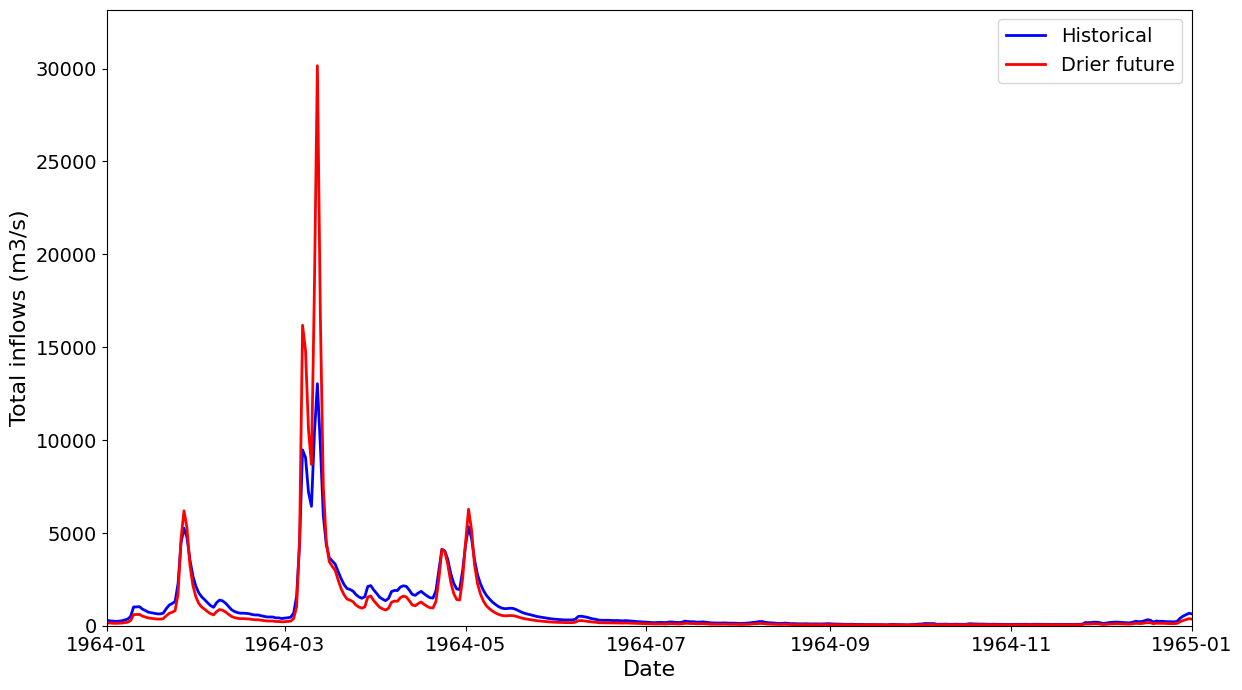

In [18]:
# We can see how inflows are modified
fig = visuals.compare_flow_timeseries(reference=pd.Series(flows_default['Total inflows (m3/s)']),
                                      alternative=pd.Series(new_flows['Total inflows (m3/s)']),
                                      labels=['Historical', 'Drier future'], 
                                      first_date=datetime.date(1964, 1, 1),
                                      last_date=datetime.date(1965, 1, 1))

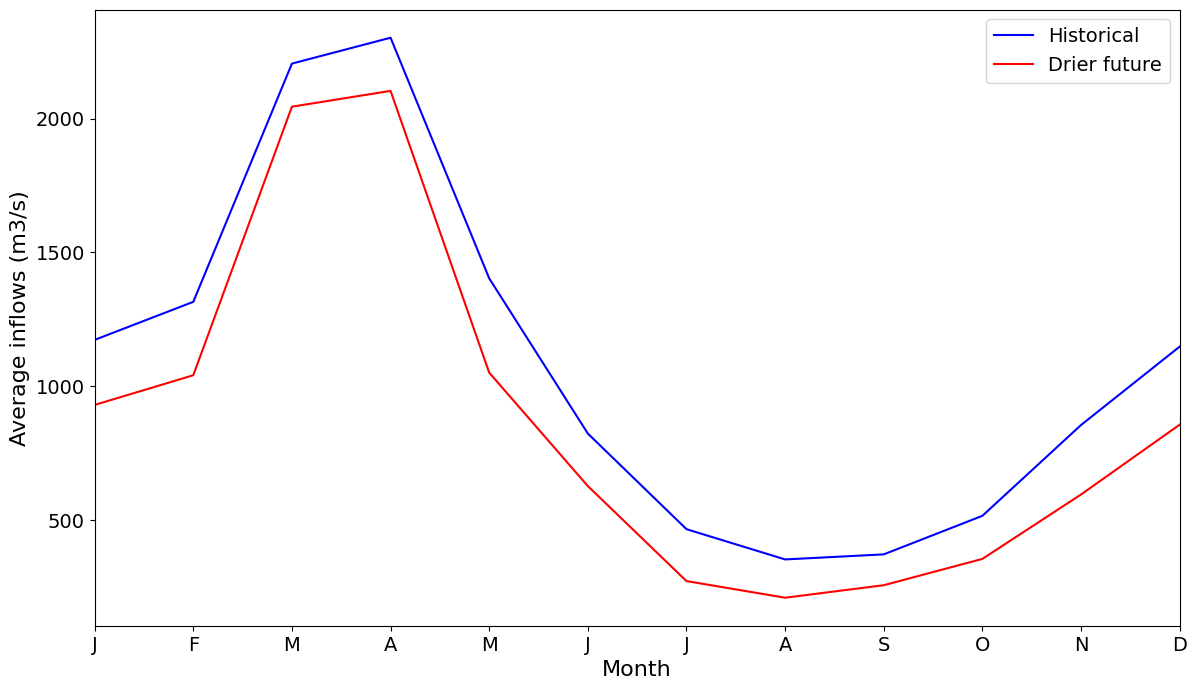

In [20]:
fig = visuals.compare_monthly_averages(reference=pd.Series(flows_default['Total inflows (m3/s)']), 
                                       alternative=pd.Series(new_flows['Total inflows (m3/s)']), 
                                       labels=['Historical', 'Drier future'])

In [24]:
# A first proposal involves lowering the intake at the nuclear plant. Let's examine its impact on performance.

# Case 1: historical inflows, current intake
water_balance_1 = flows_default.copy()
water_balance_1 = balance_calcs.sop_full(conowingo_default, water_balance_1)
metrics_1 = performance.all_metrics(conowingo_default, water_balance_1)
display(metrics_1)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,0.993547,0.048485,100%,8,0.993547
1,Chester,0.980327,0.023857,100%,12,0.980099
2,Nuclear,0.974343,0.025915,100%,17,0.972667
3,Env. flows,0.997614,0.098361,34%,6,0.999565
4,Flooding,0.999687,0.5,36%,4,N/A
5,Recreation,0.945342,0.048295,1.87m,17,N/A


In [26]:
# Case 2: future inflows, current intake
water_balance_2 = new_flows.copy()
water_balance_2 = balance_calcs.sop_full(conowingo_default, water_balance_2)
metrics_2 = performance.all_metrics(conowingo_default, water_balance_2)
display(metrics_2)

AttributeError: module 'model' has no attribute 'all_performance_metrics'

In [28]:
# Now we lower the intake for Cases 3 and 4
conowingo_safer_nuclear = copy.deepcopy(conowingo_default)
conowingo_safer_nuclear.demand_on_site[2].intake_depth = conowingo_safer_nuclear.demand_on_site[0].intake_depth
for i in range(len(conowingo_default.demand_on_site)):
    print('Intake depth for ' + conowingo_safer_nuclear.demand_on_site[i].name + ' is now set at ' +
          "{:.2f}".format(conowingo_safer_nuclear.demand_on_site[i].intake_depth) + 'm.')

Intake depth for Baltimore is now set at 5.18m.
Intake depth for Chester is now set at 2.44m.
Intake depth for Nuclear plant is now set at 5.18m.


In [30]:
# Case 3: historical inflows, lower intake
water_balance_3 = flows_default.copy()
water_balance_3 = balance_calcs.sop_full(conowingo_safer_nuclear, water_balance_3)
metrics_3 = performance.all_metrics(conowingo_safer_nuclear, water_balance_3)
display(metrics_3)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,0.993273,0.046512,100%,8,0.993273
1,Chester,0.980171,0.023669,100%,12,0.979944
2,Nuclear,0.993273,0.046512,100%,8,0.993254
3,Env. flows,0.997614,0.098361,36%,6,0.999544
4,Flooding,0.999687,0.5,36%,4,N/A
5,Recreation,0.945342,0.048295,1.89m,17,N/A


In [32]:
# Case 4: future inflows, lower intake
water_balance_4 = new_flows.copy()
water_balance_4 = balance_calcs.sop_full(conowingo_safer_nuclear, water_balance_4)
metrics_4 = performance.all_metrics(conowingo_safer_nuclear, water_balance_4)
display(metrics_4)

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,0.916497,0.024824,100%,53,0.916497
1,Chester,0.873553,0.013919,100%,45,0.872138
2,Nuclear,0.916497,0.024824,100%,53,0.912935
3,Env. flows,0.953223,0.045151,42%,54,0.982997
4,Flooding,0.997536,0.412698,74%,26,N/A
5,Recreation,0.736646,0.032429,3.50m,55,N/A


In [ ]:
# Let is recapitulate what this means for all reliabilities

reliabilities = pd.DataFrame(index=metrics_1.loc[:, 'Name'],
                             data={'HF, CI': metrics_1['Reliability (0-1)'].to_numpy(),
                                   'FF, CI': metrics_2['Reliability (0-1)'].to_numpy(),
                                   'HF, LI': metrics_3['Reliability (0-1)'].to_numpy(),
                                   'FF, LI': metrics_4['Reliability (0-1)'].to_numpy()})

print('HF: historical flows')
print('FF: future flows')
print('CI: current intake')
print('LI: lower intake\n')
print(reliabilities)

**Question: how does the lower intake affect other actors?**

Answer: the worst impact on reliability, for Chester under the climate change scenario, is still smaller than 0.1%.

**Question: how does climate change affect reliabilities?**

Answer: for all in-reservoir uses, this "middle of the road" scenario is enough to tip reliability below 95%.

# Step 1: Problem framing

Our XLRM is as follows:

**X**
* Flow variability is represented by the historical inflows time series.
* Uncertainties generated by climate change. This includes a reduction in inflows (but with increased variability), and a need to sustain higher ecological flows into Chesapeake Bay (to sustain the brackish ecosystem under moderate sea-level rise).
* Uncertainties around urban growth and the associated demand increase.
  
**L**
* We assume a standard operating policy (SOP), as in previous tutorials.
* We also assume that a new intake is built for the Peach Bottom nuclear plant, and set up at the same height as the Baltimore intake.
* We also learned from the preliminary analysis above that climate change is a risk to water supply. For this reason, Baltimore are revisiting the idea of building an alternative supply source, to which they would switch when Lake Conowingo levels start going down. Levers there are *the amount of alternative supply*, and *the reservoir level at which this is activated*.

**R**

We built a water balance model of the system in previous tutorials, and are going to use it here.

**M**

We prioritise water supply reliability here, and we use the following metrics:
* Baltimore volumetric reliability, from *all sources* (reservoir and alternative);
* Fraction of Baltimore water that comes from the reservoir;
* Chester reliability (which is the same as volumetric reliability);
* Nuclear plant reliability (which is the same as volumetric reliability);
* Environmental reliability.

# Step 2: Alternative generation

Once the problem is framed, MORDM involves finding solutions thanks to multi-objective optimisation, in order to select them. 

For this we need a model of the system to use for the optimisation. The model below uses the flows from the 1960s, a sequence of years drier than the "middle of the road" dry future would be on average. 

The decision variables are: 
1. the size of the plant (on a 0-1 scale, 0 being no plant at all and 1 a plant that serves 100% of baseline Baltimore demand).
2. the lake level below which the plant starts working, ranging between the level of the Baltimore intake (then it replaces the lake as a water source only when absolutely necessary), and the full lake level.

The objectives in the optimisation are:
1. Baltimore volumetric reliability (to maximise): that’s the fraction of demand satisfied by Lake Conowingo + desal
2. The fraction of Baltimore's demand met by the reservoir alone (to maximise: that's cheaper)
3. Chester reliability (to maximise): account for benefits to other users.

In [ ]:
# Now we define our optimization model
def optimization_problem(reduction, reduction_depth):
    """
    This function computes desired performance metrics for the decisions given in arguments.

    Arguments:
    reduction: float on [0, 1] range, the fraction of Baltimore water that has to come from desalination instead
    reduction_depth: float (in m) the amount of water the reservoir can get lower before the restriction kicks in.
                This is a regulation.

    Note that the Reservoir class object and flows pandas DataFrame that are copied are implicit arguments here.

    Outputs are:
        1) the Baltimore volumetric reliability, covered by BOTH SOURCES (reservoir and desalination)
        2) fraction of Baltimore demand served by the reservoir alone
        3) Chester reliability

    Note: we are focusing on the few dry years in the 1960s as they are drier and were therefore deemed as a good
    baseline for optimization.
    """

    # Get copies of the data so that there is an untouched original copy
    time_mask = (flows_default.index.year > 1961) & (flows_default.index.year < 1968)
    water_balance = flows_default.iloc[time_mask, :].copy()
    reservoir = copy.deepcopy(conowingo_safer_nuclear)  # Note we are assuming lowered intake.

    # Define the reduction that kicks in like a new demand
    reservoir.add_on_site_demand(model.Demand('Baltimore 2', reduction_depth))

    # Split Baltimore demand into two: the fraction immune to reductions and the one hit by it.
    total_baltimore_demand = water_balance.sum(axis=0)['Baltimore demand (m3/s)']
    water_balance['Baltimore 2 demand (m3/s)'] = water_balance['Baltimore demand (m3/s)'] * reduction
    water_balance['Baltimore demand (m3/s)'] = water_balance['Baltimore demand (m3/s)'] * (1-reduction)

    # Computing the water balance for our standard operating policy (SOP)
    model.water_balance_sop(reservoir=reservoir, water_flows=water_balance)

    # We compute performance indicators
    # 1) Baltimore volumetric reliability, from reservoir and desalination combined
    total_baltimore_suppy = water_balance.sum(axis=0)['Withdrawals Baltimore (m3/s)'] + \
                            water_balance.sum(axis=0)['Baltimore 2 demand (m3/s)']  # Since the fraction supplied by desal is always met by either source
    baltimore_vol_rel = total_baltimore_suppy / total_baltimore_demand
    # 2) Baltimore fraction from reservoir
    total_baltimore_withdrawals = water_balance.sum(axis=0)['Withdrawals Baltimore (m3/s)'] + \
                                  water_balance.sum(axis=0)['Withdrawals Baltimore 2 (m3/s)']
    baltimore_reservoir_fraction = total_baltimore_withdrawals / total_baltimore_demand
    # 3) Chester reliability
    chester_rel = model.reliability(water_balance['Withdrawals Chester (m3/s)'].to_numpy(),
                                    water_balance['Chester demand (m3/s)'].to_numpy(), True)

    return baltimore_vol_rel, baltimore_reservoir_fraction, chester_rel

In [ ]:
# Note what happens when we call the function. Look at the numbers, are they in line with a drier future?
performance = optimization_problem(0, 0)
print('Without intervention, in 1962-1967 Baltimore volumetric reliability is ' + "{:.2f}".format(performance[0]) + ',')
print('the fraction of Baltimore supply coming from the reservoir is ' + "{:.2f}".format(performance[1]) + ',')
print('and the Chester reliability is ' + "{:.2f}".format(performance[2]))

In [ ]:
# Let us now define the model for the Rhodium library
conowingo_model = rhodium.Model(optimization_problem)

# Parameters 
conowingo_model.parameters = [rhodium.Parameter('reduction'),
                              rhodium.Parameter('reduction_depth')]

# Parameters are levers
conowingo_model.levers = [rhodium.RealLever('reduction', 0.0, 1.0),
                          rhodium.RealLever('reduction_depth', 0.0, conowingo_default.demand_on_site[0].intake_depth)]

# Objectives
conowingo_model.responses = [rhodium.Response('baltimore_vol_rel', rhodium.Response.MAXIMIZE),
                             rhodium.Response('baltimore_reservoir_fraction', rhodium.Response.MAXIMIZE),
                             rhodium.Response('chester_rel', rhodium.Response.MAXIMIZE)]

In [ ]:
# Optimization
carryout_optimize = 0  # Set to 0 to not run optimization every time you run the Notebook!

if carryout_optimize == 1:
    # Run optimization
    output = rhodium.optimize(conowingo_model, 'NSGAII', 2000)
    print("Found", len(output), "optimal policies!")
    # Optional: save output as pandas DataFrame for further manipulation
    output_df = output.as_dataframe()
    output_df.to_csv('optimization_results.csv', index_label='Solution number')

In [ ]:
# Plotting: scatter 2D plot
if carryout_optimize == 1:
    fig = rhodium.scatter2d(conowingo_model, output, c='chester_rel')

In [ ]:
# Plotting: parallel plot
if carryout_optimize == 1:
    fig = rhodium. parallel_coordinates(conowingo_model, output, colormap='RdBu', target='top',
                                        brush=[rhodium.Brush("baltimore_vol_rel > 0.99 and chester_rel > 0.86"),
                                               rhodium.Brush("baltimore_vol_rel > 0.99 and chester_rel <=0.86")])

**Question 1:** (A) Why no other objectives? (B) Why mix reliability with volumetric reliability? (C) Does there seem to be trade-offs as far as Baltimore alone is considered?

### Step 3: Alternative selection

We want to select solutions that:

* Keep Baltimore volumetric reliability over 0.99 even in the dry period chosen.
* Appreciably improve Chester's reliability (well over 0.84; here 0.86 is chosen)
* Is the cheapest in terms of capital costs to meet these constraints

In [ ]:
# Select cheapest (capital costs) solution for Baltimore volumetric reliability > 0.99 and Chester reliability > 0.86
output_df = pd.read_csv('optimization_results.csv', index_col='Solution number')
solution_mask = (output_df['baltimore_vol_rel'] > 0.99) & (output_df['chester_rel'] > 0.86)
selected_solution = output_df[solution_mask].idxmin(axis=0)['reduction']
print('\nWe selected solution number ' + str(selected_solution) + ' with the following characteristics:')
print(output_df.iloc[selected_solution, :])

**Now we can resimulate this solution under (1) the historical record, and (2) the "middle of the road" dry future, to check performance before selecting it.**
We need a simulator for that, it is defined now.

In [ ]:
def simulation_problem(reduction,
                       reduction_depth,
                       mean_multiplier,
                       std_multiplier,
                       first_p_multiplier,
                       environmental_multiplier,
                       domestic_multiplier):
    """
    This function computes desired performance metrics for the decisions given in arguments.

    Arguments are the two levers and a list of five uncertain factors that correspond to the X of our XLRM

        The levers (L):
        reduction: float on [0, 1] range, the fraction of Baltimore water that has to come from desalination instead
        reduction_depth: float (in m) the amount of water the reservoir can get lower before the restriction kicks in.
                This is a regulation.

        The uncertain factors (X):
        mean_multiplier: float, the change in the streamflow average
        std_multiplier: float, the change in the standard deviation of streamflows
        first_p_multiplier: float, the change in the first percentile of flow
        environmental_multiplier: float, the change in environmental demand
        domestic_demand: float, the change in domestic demand (from both Chester and Baltimore

    Note that the Reservoir class object and flows pandas DataFrame that are copied are implicit arguments here.

    Outputs are:
        1) the Baltimore volumetric reliability, covered by BOTH SOURCES (reservoir and desalination)
        2) Chester reliability
        3) Nuclear plant reliability
        4) Environmental reliability
    """

    # Get a copy of the reservoir data so that there is an untouched original copy
    reservoir = copy.deepcopy(conowingo_safer_nuclear)  # Note we are assuming lowered nuclear plant intake.

    # Get a copy of the flow data that leaves the original untouched and incorporates flow multipliers at the same time!
    water_balance = model.perturbed_flows(flows_original=flows_default,
                                          perturbed_multipliers=[mean_multiplier, std_multiplier, first_p_multiplier],
                                          low_quantile=1)

    # Now we account for our demand multipliers
    # Environmental
    water_balance['Environmental demand (m3/s)'] = water_balance[
                                                       'Environmental demand (m3/s)'] * environmental_multiplier
    # Chester
    water_balance['Chester demand (m3/s)'] = water_balance['Chester demand (m3/s)'] * domestic_multiplier
    # Baltimore
    water_balance['Baltimore demand (m3/s)'] = water_balance['Baltimore demand (m3/s)'] * domestic_multiplier

    # Define the reduction that kicks in like a new demand
    reservoir.add_on_site_demand(model.Demand('Baltimore 2', reduction_depth))

    # Split Baltimore demand into two: the fraction immune to reductions and the one hit by it.
    # Note the desalination plant does not change size when Baltimore demand increases
    actual_reduction = max(1, reduction / domestic_multiplier)
    total_baltimore_demand = water_balance.sum(axis=0)['Baltimore demand (m3/s)']
    water_balance['Baltimore 2 demand (m3/s)'] = water_balance['Baltimore demand (m3/s)'] * actual_reduction
    water_balance['Baltimore demand (m3/s)'] = water_balance['Baltimore demand (m3/s)'] * (1-actual_reduction)

    # Computing the water balance for our standard operating policy (SOP)
    model.water_balance_sop(reservoir=reservoir, water_flows=water_balance)

    # We compute performance indicators
    # 1) Baltimore volumetric reliability, from reservoir and desalination combined
    total_baltimore_suppy = water_balance.sum(axis=0)['Withdrawals Baltimore (m3/s)'] + \
                            water_balance.sum(axis=0)['Baltimore 2 demand (m3/s)']  # Since the fraction supplied by desal is always met by either source
    baltimore_vol_rel = total_baltimore_suppy / total_baltimore_demand
    # 2) Chester reliability
    chester_rel = model.reliability(water_balance['Withdrawals Chester (m3/s)'].to_numpy(),
                                    water_balance['Chester demand (m3/s)'].to_numpy(), True)
    # 3) Nuclear plant reliability
    nuclear_rel = model.reliability(water_balance['Withdrawals Nuclear plant (m3/s)'].to_numpy(),
                                    water_balance['Nuclear plant demand (m3/s)'].to_numpy(), True)
    # 4) Environmental reliability
    env_rel = model.reliability(water_balance['Outflows (m3/s)'].to_numpy(),
                                water_balance['Environmental demand (m3/s)'].to_numpy(), True)

    return baltimore_vol_rel,  chester_rel, nuclear_rel, env_rel

In [ ]:
# Simulate selected solution and compare performance to the no-action solution
# Under historical flows
performance_current = simulation_problem(output_df.loc[selected_solution, 'reduction'],
                                         output_df.loc[selected_solution, 'reduction_depth'],
                                         1, 1, 1, 1, 1)
print('\nUnder historical flows:')
print('After infrastructure development Baltimore volumetric reliability would be ' + "{:.3f}".format(performance_current[0]) + ' vs. ' + "{:.3f}".format(metrics_1.iloc[0, 5]) + ' before.')
print('After infrastructure development the nuclear plant reliability would be ' + "{:.3f}".format(performance_current[2]) + ' vs. ' + "{:.3f}".format(metrics_1.iloc[2, 1]) + ' before.')
print('After infrastructure development Chester reliability would be ' + "{:.3f}".format(performance_current[1]) + ' vs. ' + "{:.3f}".format(metrics_1.iloc[1, 1]) + ' before.')
print('After infrastructure development environmental reliability would be ' + "{:.3f}".format(performance_current[3]) + ' vs. ' + "{:.3f}".format(metrics_1.iloc[3, 1]) + ' before.')

In [ ]:
# Under the selected drier future
performance_future = simulation_problem(output_df.loc[selected_solution, 'reduction'],
                                        output_df.loc[selected_solution, 'reduction_depth'],
                                        multiplier_mean, multiplier_std, multiplier_lowflow, 1, 1)
print('\nUnder the selected drier future:')
print('After infrastructure development Baltimore volumetric reliability would be ' + "{:.3f}".format(performance_future[0]) + ' vs. ' + "{:.3f}".format(metrics_2.iloc[0, 5]) + ' before.')
print('After infrastructure development the nuclear plant reliability would be ' + "{:.3f}".format(performance_future[2]) + ' vs. ' + "{:.3f}".format(metrics_2.iloc[2, 1]) + ' before.')
print('After infrastructure development Chester reliability would be ' + "{:.3f}".format(performance_future[1]) + ' vs. ' + "{:.3f}".format(metrics_2.iloc[1, 1]) + ' before.')
print('After infrastructure development environmental reliability would be ' + "{:.3f}".format(performance_future[3]) + ' vs. ' + "{:.3f}".format(metrics_2.iloc[3, 1]) + ' before.')

# Step 4: Vulnerability analysis (Scenario discovery)

Having checked that the selected solution improves performance across objectives for the selected flow scenarios, we want to conduct a more in-depth analysis to understand how performance evolves in the future.

Let's use Rhodium for that. First, let's redefine the model based on the simulation problem (note the difference with the optimization setup).

In [ ]:
# Model definition (R)
simulation_model = rhodium.Model(simulation_problem)

# All parameters: uncertainty (X) and levers (L)
simulation_model.parameters = [rhodium.Parameter('reduction'),
                               rhodium.Parameter('reduction_depth'),
                               rhodium.Parameter('mean_multiplier'),
                               rhodium.Parameter('std_multiplier'),
                               rhodium.Parameter('first_p_multiplier'),
                               rhodium.Parameter('environmental_multiplier'),
                               rhodium.Parameter('domestic_multiplier')]

# Performance metrics (M)
simulation_model.responses = [rhodium.Response('baltimore_vol_rel', rhodium.Response.MAXIMIZE),
                              rhodium.Response('chester_rel', rhodium.Response.MAXIMIZE),
                              rhodium.Response('nuclear_rel', rhodium.Response.MAXIMIZE),
                              rhodium.Response('env_rel', rhodium.Response.MAXIMIZE)]

In [ ]:
# Let's incorporate the chosen infrastructure policy
policy = {'reduction': output_df.loc[selected_solution, 'reduction'],
          'reduction_depth': output_df.loc[selected_solution, 'reduction_depth']}
print('The chosen infrastructure design is:')
print(policy)

In [ ]:
# Defining the uncertainty ranges
simulation_model.uncertainties = [rhodium.UniformUncertainty('mean_multiplier', 0.6, 1),
                                  rhodium.UniformUncertainty('std_multiplier', 1, 1.5),
                                  rhodium.UniformUncertainty('first_p_multiplier', 0.3, 1),
                                  rhodium.UniformUncertainty('environmental_multiplier', 1, 1.4),
                                  rhodium.UniformUncertainty('domestic_multiplier', 1, 1.4)]

Now we define a **sampling strategy**, here, based on latin hypercube sampling.

In [ ]:
plausible_futures = rhodium.sample_lhs(simulation_model, 500)

Now we perform the **vulnerability analysis**.

In [ ]:
vulnerability_analysis = 1

if vulnerability_analysis == 1:
    results = rhodium.evaluate(simulation_model, rhodium.update(plausible_futures, policy))
    # Optional: save output as pandas DataFrame for further manipulation
    result_table = results.as_dataframe()
    result_table.to_csv('vulnerability_analysis_results.csv', index_label='sample number')

In [ ]:
# Load results: see how table contains both all parameters (the policy, then the uncertain sampled values), and all performance metrics.
result_table = pd.read_csv('vulnerability_analysis_results.csv', index_col='sample number')
print(result_table)

In [ ]:
# Define variable to explore and threshold
metric_name = 'chester_rel'
satisfaction_threshold = 0.90

In [ ]:
if vulnerability_analysis == 1:
    classification = results.apply("'Success' if  " + metric_name + " > " + str(satisfaction_threshold) + " else 'Failure'")
    prim_results = rhodium.Prim(results, classification, include=simulation_model.uncertainties.keys(), coi="Success")
    box = prim_results.find_box()
    box.show_details()

In [ ]:
# Function to plot successes and failures
def vulnerability_plots(rhodium_model, vul_results, uncertainty_1, uncertainty_2, performance_metric, threshold):
    """
    Plotting successes and failures in 2D scatter plots
    :param rhodium_model: the model, defined by the Rhodium library
    :param vul_results: a pandas DataFrame containing all inputs and output values
    :param uncertainty_1: String, the uncertain parameter to put on the x-axis
    :param uncertainty_2: String, the uncertain parameter to put on the y-axis
    :param performance_metric: String, the metric used to assess performance
    :param threshold: float, the threshold that determines whether a future is a success or a failure
    :return: figure
    """

    # Whether we want to be above the threshold (the Rhodium response need to be maximized, dir=1)
    # or below the threshold (the Rhodium response need to be minimized, dir=-1)
    above_or_below = rhodium_model.responses[performance_metric].dir

    # Define success and failure points
    success_results = vul_results[above_or_below * vul_results[performance_metric] >= above_or_below * threshold]
    failure_results = vul_results[above_or_below * vul_results[performance_metric] < above_or_below * threshold]

    # Scatter plot of results
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(success_results[uncertainty_1], success_results[uncertainty_2], c='r', marker='o', label='Success')
    ax.scatter(failure_results[uncertainty_1], failure_results[uncertainty_2], c='b', marker='+', label='Failure')

    # Labels
    ax.set_xlabel(uncertainty_1, size=14)
    ax.set_ylabel(uncertainty_2, size=14)

    # Set the limits to the plot
    ax.set_xlim(rhodium_model.uncertainties[uncertainty_1].min_value,
                rhodium_model.uncertainties[uncertainty_1].max_value)
    ax.set_ylim(rhodium_model.uncertainties[uncertainty_2].min_value,
                rhodium_model.uncertainties[uncertainty_2].max_value)

    return fig

In [ ]:
# PLots!
print('Red dots are successes, blue crosses are failures')
for i in range(len(simulation_model.uncertainties)):
    for j in np.arange(i+1, len(simulation_model.uncertainties), 1):
        fig = vulnerability_plots(simulation_model, result_table, simulation_model.uncertainties[i].name,
                                  simulation_model.uncertainties[int(j)].name, metric_name, satisfaction_threshold)

**Question 3.** Interpret the results after running reliabilities for different actors and different reliability thresholds. In particular, what uncertainties matter most / don't matter for the different objectives?